In [1]:
import pandas as pd
import pymc_marketing as pmm
import matplotlib as mpl
import matplotlib.pyplot as plt
from cabm import post_processing as ppr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figure setup
# Set the font to Courier
mpl.rcParams['font.family'] = 'Courier'

# Set the line weight to thin
mpl.rcParams['lines.linewidth'] = 0.75

# Set the color scheme to black and white
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

In [4]:
agent_df = pd.read_pickle('agent_output_ad_with_increment.pkl')

In [5]:
agent_df = ppr.add_date_column(agent_df)

In [6]:
data_A = ppr.calculate_total_purchases(agent_df, ['price_A','tv_A','web_A', 'price_B', 'tv_B', 'web_B'], ['Total_Purchases_A', 'Total_Purchases_B'])


In [7]:
data_A = ppr.add_total_sales_columns(data_A, ['Total_Purchases_A', 'Total_Purchases_B'],  ['price_A','price_B'],)

In [8]:
data_A = ppr.ensure_float_columns(data_A, exclude_columns=['Date','Step'])

In [9]:
data_A

,Date,Step,price_A,tv_A,web_A,price_B,tv_B,web_B,Total_Purchases_A,Total_Purchases_B,Total_Sales_A,Total_Sales_B
0,2021-01-03,0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-10,1,5.0,0.0,0.0,5.0,0.0,0.0,45.0,11.0,225.0,55.0
2,2021-01-17,2,5.0,0.0,0.0,5.0,0.0,0.0,260.0,141.0,1300.0,705.0
3,2021-01-24,3,5.0,0.0,0.0,5.0,0.0,0.0,438.0,206.0,2190.0,1030.0
4,2021-01-31,4,5.0,125000.0,0.0,5.0,0.0,0.0,515.0,258.0,2575.0,1290.0
...,...,...,...,...,...,...,...,...,...,...,...,...
151,2023-11-26,151,5.0,0.0,0.0,5.0,0.0,0.0,552.0,160.0,2760.0,800.0
152,2023-12-03,152,5.0,0.0,0.0,5.0,0.0,0.0,616.0,192.0,3080.0,960.0
153,2023-12-10,153,5.0,0.0,0.0,5.0,0.0,0.0,594.0,220.0,2970.0,1100.0
154,2023-12-17,154,5.0,0.0,0.0,5.0,0.0,0.0,628.0,180.0,3140.0,900.0


In [10]:
data_a_mod = data_A[52:].reset_index(drop=True)

In [11]:
data_a_mod['Total_Sales_A'] = data_a_mod['Total_Sales_A'] * 100 #scaled so ad spend is approx 20% of sales
data_a_mod['Total_Sales_B'] = data_a_mod['Total_Sales_B'] * 100 #scaled so ad spend is approx 20% of sales

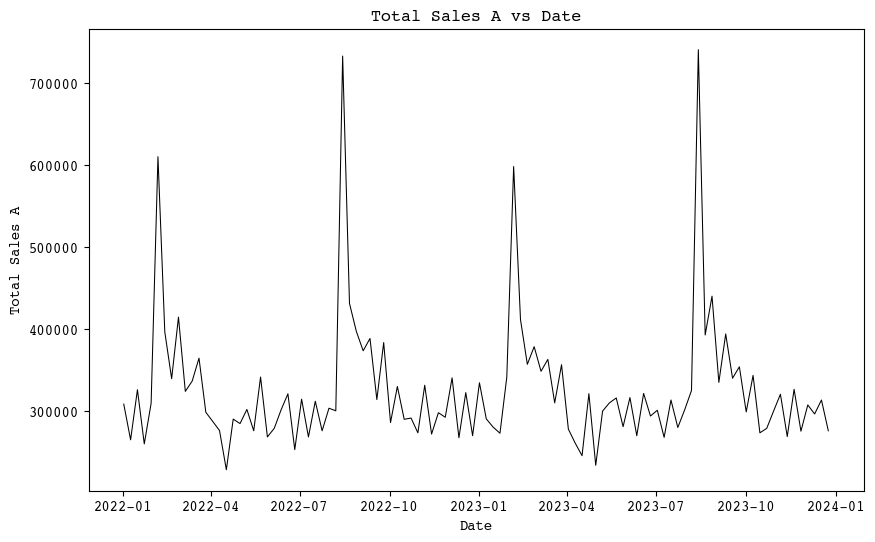

In [12]:
plt.figure(figsize=(10,6))
plt.plot(data_a_mod['Date'], data_a_mod['Total_Sales_A'],color='black')
plt.xlabel('Date')
plt.ylabel('Total Sales A')
plt.title('Total Sales A vs Date')
plt.show()


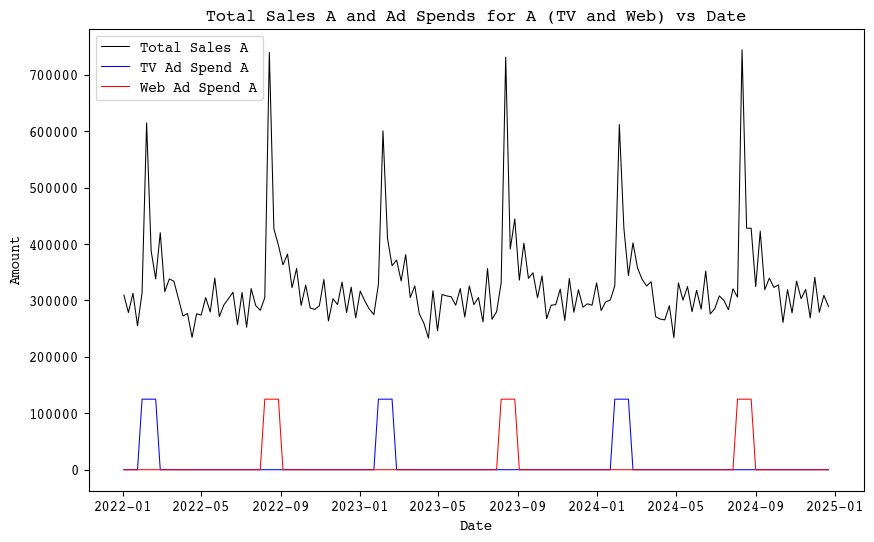

In [12]:
plt.figure(figsize=(10,6))
plt.plot(data_a_mod['Date'], data_a_mod['Total_Sales_A'], color='black', label='Total Sales A')
plt.plot(data_a_mod['Date'], data_a_mod['tv_A'], color='blue', label='TV Ad Spend A')
plt.plot(data_a_mod['Date'], data_a_mod['web_A'], color='red', label='Web Ad Spend A')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Total Sales A and Ad Spends for A (TV and Web) vs Date')
plt.legend()
plt.show()


In [13]:
data_a_mod.to_csv("sim_data_trunc.csv", index=False)

In [14]:
# Calculate the percentage of ad spend to sales for both brands A and B
data_a_mod['Ad_Spend_to_Sales_A'] = (data_a_mod['tv_A'] + data_a_mod['web_A']) / data_a_mod['Total_Sales_A'] * 100
data_a_mod['Ad_Spend_to_Sales_B'] = (data_a_mod['tv_B'] + data_a_mod['web_B']) / data_a_mod['Total_Sales_B'] * 100


In [23]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import pymc.sampling_jax
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

In [17]:
# Create a coordinate system based on dates
coords = {"Date": data_a_mod["Date"].values}

# Transform 'Date' to numerical format: days since the first date
data_a_mod['DateDays'] = (data_a_mod['Date'] - data_a_mod['Date'].min()).dt.days

In [37]:
# Begin probabilistic modeling
with pm.Model(coords=coords) as model:
    # Initial setup for the Gaussian Process
    eta = pm.Exponential("eta", lam=1)
    
    # Define constraints for the length scale of our GP. 
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=1, upper=10, 
        init_guess={"alpha": 2, "beta": 20},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Define the covariance function
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    # Establish the Gaussian Process
    gp = pm.gp.HSGP(m=[40], c=2.0, cov_func=cov)
    f = gp.prior("f", X=data_a_mod['DateDays'].values[:, None], dims="Date")
    
    # Estimate the average sales
    intercept = pm.Normal("intercept", mu=data_a_mod["Total_Sales_A"].mean(), sigma=2 * data_a_mod["Total_Sales_A"].std())
    
    # Model the media effect
    media_coef = pm.HalfNormal("media_coef", sigma=100)
    lam = pm.Gamma('lam', alpha=1, beta=1)
    alpha = pm.Beta('alpha', alpha=1, beta=1)

    media_impact = pm.Deterministic(
        "media_impact",
        media_coef * 
        logistic_saturation(
            geometric_adstock(data_a_mod["tv_A"] + data_a_mod["web_A"], alpha=alpha, normalize=True, l_max=30),
            lam=lam
        )
    )
    # Combine effects
    base_prediction = pm.Deterministic("base_prediction", intercept + f, dims="Date")
    mu = pm.Deterministic("mu", base_prediction + media_impact, dims="Date")
    
    # Estimate the variability in sales
    sigma = pm.HalfNormal("sigma", sigma=2 * data_a_mod["Total_Sales_A"].std())
    
    # The final probabilistic model for sales
    pm.Normal("y", mu=mu, sigma=sigma, observed=data_a_mod["Total_Sales_A"].values)

Sampling: [alpha, ell, eta, f_hsgp_coeffs_, intercept, lam, media_coef, sigma, y]


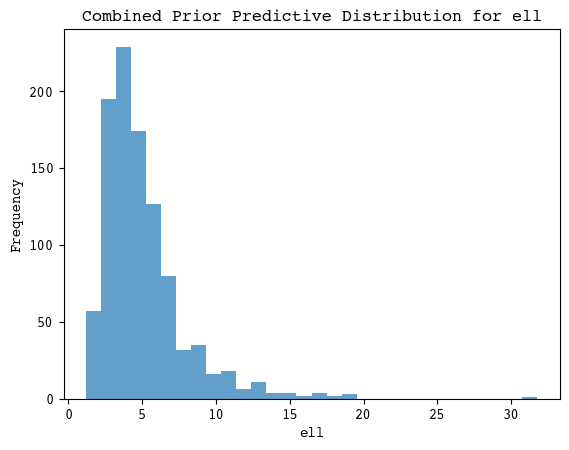

In [38]:
import pymc as pm
import matplotlib.pyplot as plt

# Assuming 'model' is your PyMC model defined in the context manager
with model:
    # Sample from the prior predictive distribution
    prior_predictive = pm.sample_prior_predictive(samples=1000)

# Extract the prior samples for 'ell'
ell_prior_samples = prior_predictive.prior['ell']

# Convert to a NumPy array and flatten
ell_prior_samples_flat = ell_prior_samples.values.flatten()

# Visualize the combined prior predictive samples for 'ell'
plt.hist(ell_prior_samples_flat, bins=30, alpha=0.7)
plt.title('Combined Prior Predictive Distribution for ell')
plt.xlabel('ell')
plt.ylabel('Frequency')
plt.show()

In [39]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=1000, draws=1000)
print("Divergences:", int(idata.sample_stats.diverging.sum().values))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Divergences: 0


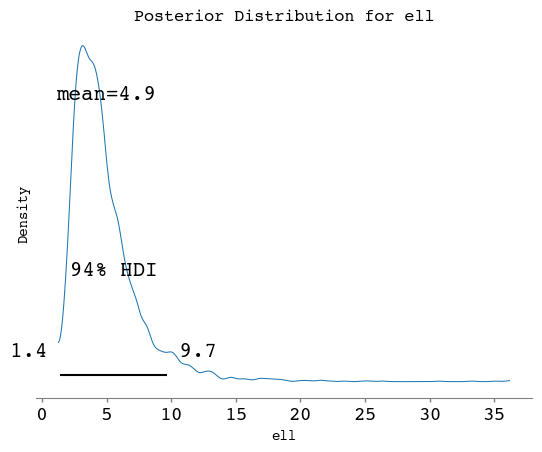

In [40]:
# Assuming 'idata' is the InferenceData object returned by pm.sample()
# Extract the posterior samples for 'ell'
ell_posterior_samples = idata.posterior['ell']

# Visualize the posterior distribution for 'ell'
az.plot_posterior(ell_posterior_samples)
plt.title('Posterior Distribution for ell')
plt.xlabel('ell')
plt.ylabel('Density')
plt.show()

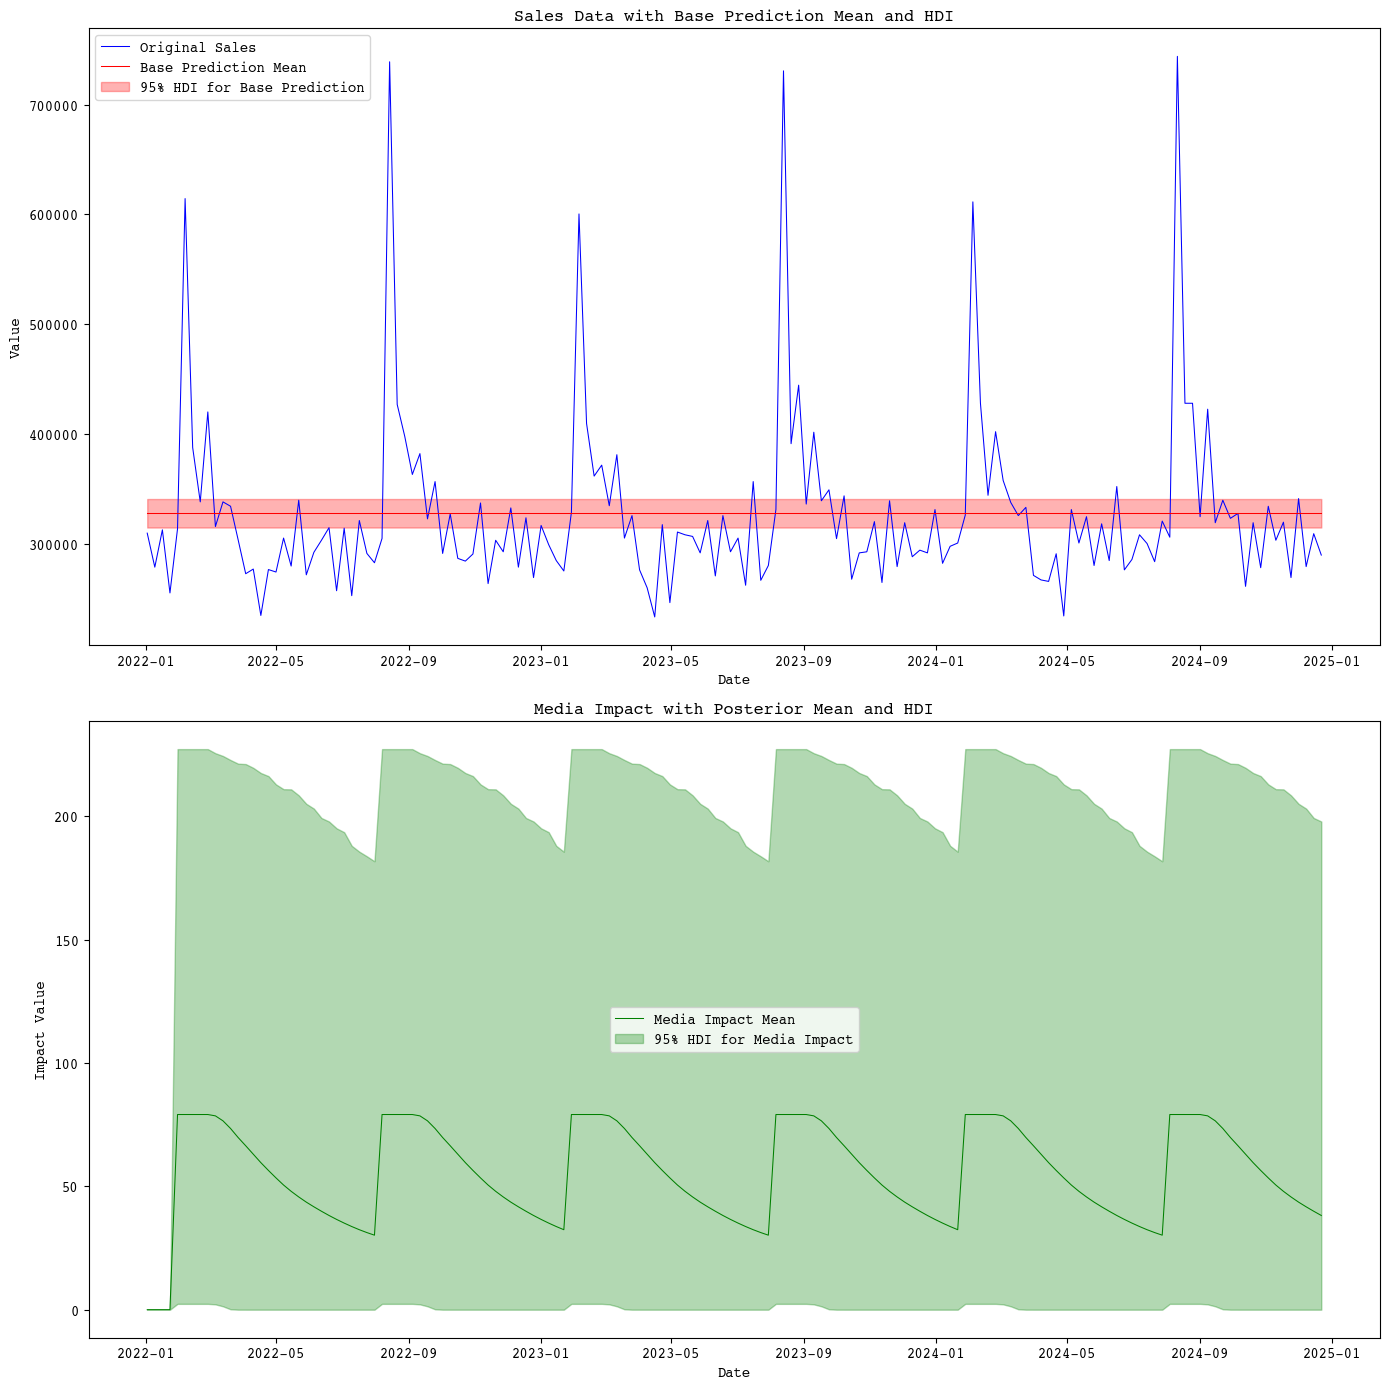

In [41]:
import matplotlib.pyplot as plt

# Compute the mean, lower, and upper HDI for "mu" across draws
base_mean = idata.posterior["base_prediction"].mean(dim=["draw", "chain"])
hdi_lower = idata.posterior["base_prediction"].quantile(0.025, dim=["draw", "chain"])
hdi_upper = idata.posterior["base_prediction"].quantile(0.975, dim=["draw", "chain"])

# Assuming you've also computed mean, lower, and upper HDI for media_impact
media_impact_mean = idata.posterior["media_impact"].mean(dim=["draw", "chain"])
media_impact_hdi_lower = idata.posterior["media_impact"].quantile(0.025, dim=["draw", "chain"])
media_impact_hdi_upper = idata.posterior["media_impact"].quantile(0.975, dim=["draw", "chain"])

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

# First Subplot: Sales Data with Base Prediction and HDI
ax1.plot(data_a_mod['Date'], data_a_mod['Total_Sales_A'], label='Original Sales', color='blue')
ax1.plot(data_a_mod['Date'], base_mean, label='Base Prediction Mean', color='red')
ax1.fill_between(data_a_mod['Date'], hdi_lower, hdi_upper, color='red', alpha=0.3, label='95% HDI for Base Prediction')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
ax1.set_title('Sales Data with Base Prediction Mean and HDI')
ax1.legend()

# Second Subplot: Media Impact
ax2.plot(data_a_mod['Date'], media_impact_mean, label='Media Impact Mean', color='green')
ax2.fill_between(data_a_mod['Date'], media_impact_hdi_lower, media_impact_hdi_upper, color='green', alpha=0.3, label='95% HDI for Media Impact')
ax2.set_xlabel('Date')
ax2.set_ylabel('Impact Value')
ax2.set_title('Media Impact with Posterior Mean and HDI')
ax2.legend()

plt.tight_layout()
plt.show()